<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv' # getting github url
cs_data = pd.read_csv(url_cs) # getting data from github

In [ ]:
diff_TminusE = cs_data.theo - cs_data.exp # difference from theoretical and experimental. This is what will be modelled
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE) # putting differences into pandas dataframe

In [ ]:
aa_encode = pd.Categorical(cs_data['aa']) # gets all the different amino acids and finds the categories
aa_idx = aa_encode.codes # gets all the amino acids in the data and finds their index in the
aa_coords = {"aa": aa_encode.categories} # dictionary of the array of the amino acid types

Old model from notes

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_nh = pm.sample()

Output()

Output()

New model with T (and half T) distributions

In [ ]:
with pm.Model(coords=aa_coords) as cs_th_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 1)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 1)
    μ_nu = pm.HalfStudentT('μ_nu', sigma= 10, nu = 1) # Very unsure, so high sigma and low nu

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = 1,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_th = pm.sample()

Output()

Output()

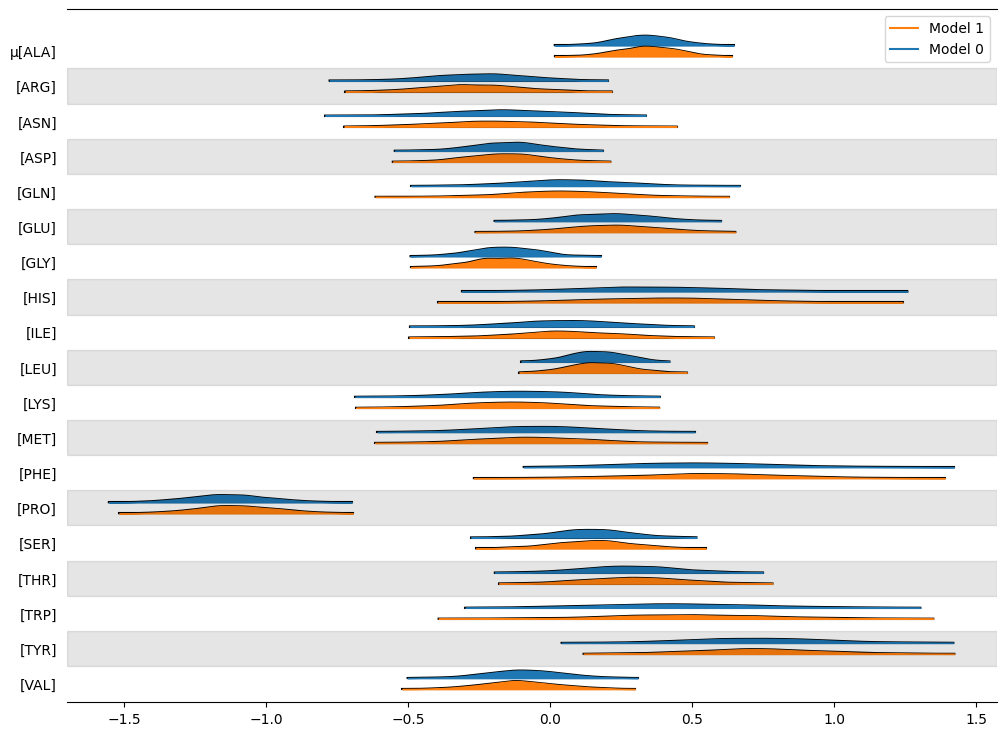

In [ ]:
axes = az.plot_forest([idata_cs_th,idata_cs_nh], kind="ridgeplot", # ridge plot of model with Ts
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Blue is with T distributions and orange is with Normal distributions. I'd say there is an insignificant difference between the two since the graphs are pretty close. This is just from my eyes though. A ppc should show which is better.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

**Normal Priors**

Output()

<Axes: xlabel='y'>

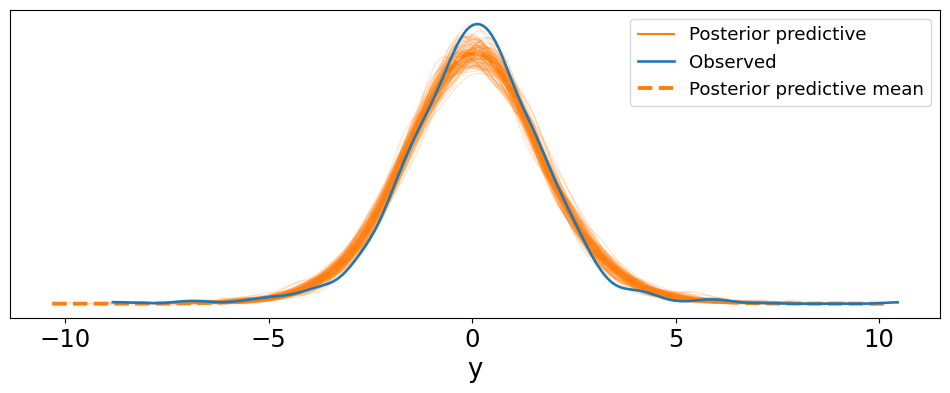

In [ ]:
pm.sample_posterior_predictive(idata_cs_nh, model=cs_h_model, extend_inferencedata=True, var_names=['y'])
az.plot_ppc(idata_cs_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**T Distribution Priors**

Output()

<Axes: xlabel='y'>

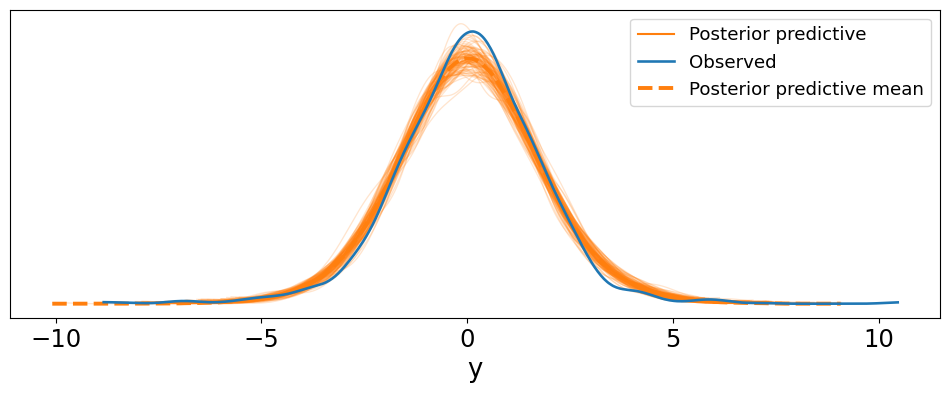

In [ ]:
pm.sample_posterior_predictive(idata_cs_th, model=cs_th_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_th, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The same again. Neither is better, they are both pretty good. They are so similar that I think I might have done something wrong. This would hopefully be the case since T distributions and normal distributions aren't too different and priors shouldn't affect the posterior too much.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}


In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:

    μ_p = pm.Beta('μ_p', mu = .5, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

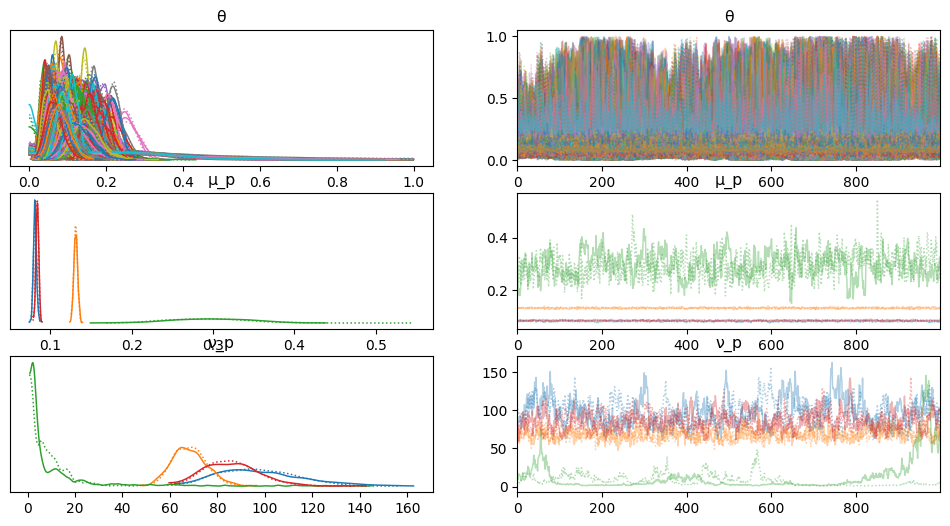

In [ ]:
az.plot_trace(idata_sccr)

In [ ]:
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9998 1.001 1.002 1.0 ... 0.9998 1.002 1.0
    μ_p      (pos) float64 32B 1.003 1.003 1.015 1.001
    ν_p      (pos) float64 32B 1.006 1.005 1.136 1.004

The rhat values are all lower and it's more confident that goolkeepers shoot better. Since the rhat values are lower, this version of the model is likely more confident and better. The value of v_p and u_p for goalkeepers is noticeably different in this model. v_p is lower and u_p is higher. Theta is also really wonky for some reason.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

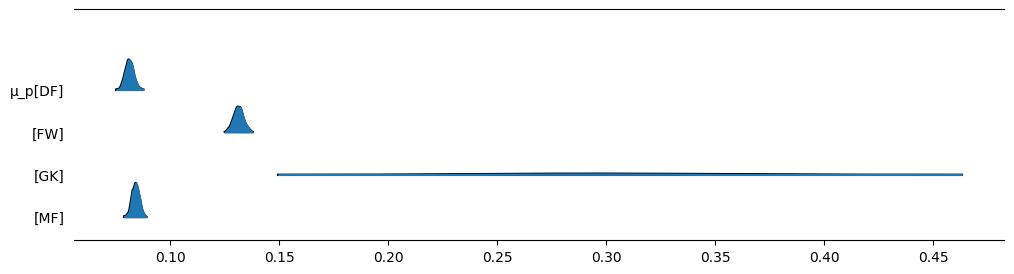

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Goalkeepers are just better shooters I guess. The means of all the other positions look the same but goal keepers have a higher mean.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
notGK = sccr_data.query('position != \'GK\'')
notGK

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
not_GK_idx = notGK.position.cat.remove_categories(['GK']).cat.codes.values # query sucks it couldn't even update the index
not_GK_codes = notGK.position.cat.remove_categories(['GK']).cat.categories
sccr_ngk_coords = {"pos": not_GK_codes}


print(not_GK_idx)
print(not_GK_codes)
print(type(notGK.position))

[1 0 2 ... 2 2 0]
Index(['DF', 'FW', 'MF'], dtype='object')
<class 'pandas.core.series.Series'>


In [ ]:
with pm.Model(coords = sccr_ngk_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[not_GK_idx], nu = ν_p[not_GK_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = notGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = notGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr2 = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

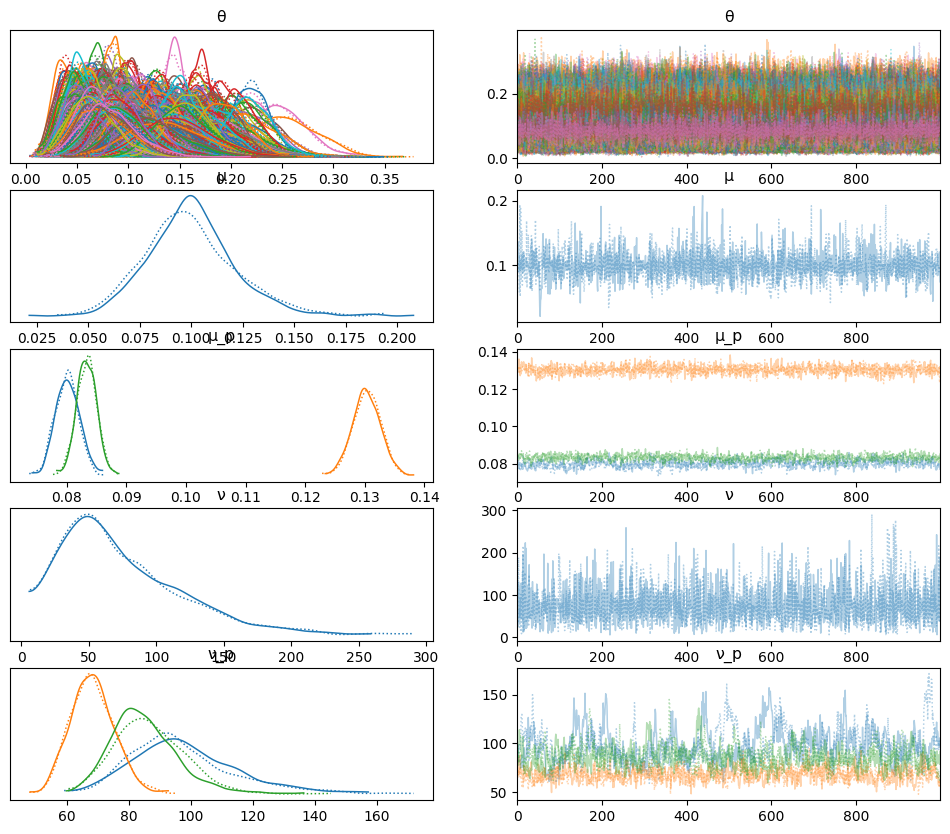

In [ ]:
az.plot_trace(idata_sccr2)

In [ ]:
az.rhat(idata_sccr2)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.003 1.002 1.004 0.9994 ... 1.001 1.0 1.0
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.023 0.9997 0.9999
    ν        float64 8B 1.002
    ν_p      (pos) float64 24B 1.042 1.008 1.015

array([<Axes: >], dtype=object)

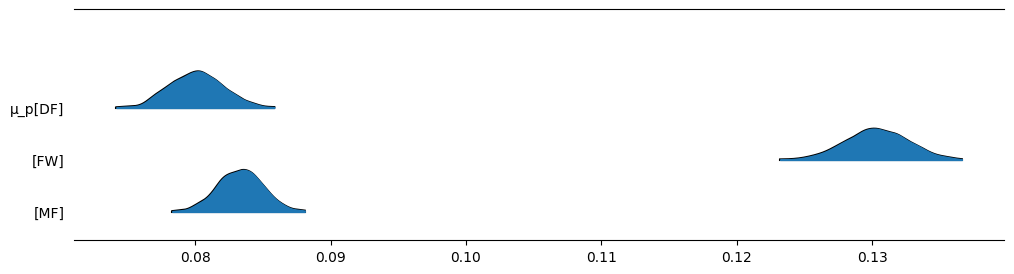

In [ ]:
az.plot_forest(idata_sccr2, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The rhat values were around the same as the hierarchichal model with GKs DF has higher values and the hyperpriors have lower values. The plot trace was also very similar, except for theta which has less variability.

The model without GKs was a bit easier for pymc to process. It took 30 less seconds to run, but other than that it was mostly the same.

Since the goalkeepers shooting percents aren't really dependent on the other positions, using a hiererarchical model made pymc predict goalkeepers poorly.

All we lost by dropping GKs from the dataset was a prediction for GKs. They weren't really dependept with the other positions so they didn't help the model. We gained a model that has more sound assumptions but the actual output didn't change much other than the hyperpriors working better.